In [8]:
import pandas as pd
import numpy as np
import librosa

In [2]:
df = pd.read_csv(r'../data/dataframes/sp_labeled.csv')

#### Cleaning the labeled dataset

In [3]:
def get_summary(df):
    summary_df = pd.DataFrame({
        'Non-NA Count': df.notna().sum(),
        'NA Count': df.isna().sum(),
        'Data Type': df.dtypes
    })
    return summary_df

get_summary(df)

,Non-NA Count,NA Count,Data Type
SongID,554,0,int64
TrackName,554,0,object
Artists,554,0,object
Genre,482,72,object
FilePath,554,0,object
sp_danceability,529,25,float64
sp_energy,529,25,float64
sp_key,529,25,float64
sp_loudness,529,25,float64
sp_speechiness,529,25,float64


Get rid of rows with no chorus start/stop time.
Rows with no first chorus start times meant they were skipped during the labeling process

In [4]:
df = df.dropna(subset=['chorus_start_1'])
df = df.loc[df['chorus_start_1'].str.strip().astype(bool)]
df = df.reset_index(drop=True)

Convert label time format into seconds with 1 decimal

In [5]:
# Function to convert label columns from hh:mm:ss.f to seconds with one decimal
def convert_to_seconds(time_str):
    if pd.isna(time_str):
        return None  # Keep NA values as they are
    try:
        # Split the string and convert to timedelta
        h, m, s = time_str.split(':')
        sec = int(h) * 3600 + int(m) * 60 + float(s)
        return '{:.1f}'.format(sec)  # Format with one decimal point
    except Exception as e:
        print(f"Error converting time: {e}")
        return None
        
time_columns = ['chorus_start_1', 'chorus_start_2', 'chorus_start_3',
                'chorus_end_1', 'chorus_end_2', 'chorus_end_3']

for col in time_columns:
    df[col] = df[col].apply(convert_to_seconds)

In [6]:
# Summary DataFrame with NA counts, non-NA counts, and data types
summary_df = pd.DataFrame({
    'Non-NA Count': df.notna().sum(),
    'NA Count': df.isna().sum(),
    'Data Type': df.dtypes
})

# Display summary DataFrame
summary_df

,Non-NA Count,NA Count,Data Type
SongID,332,0,int64
TrackName,332,0,object
Artists,332,0,object
Genre,294,38,object
FilePath,332,0,object
sp_danceability,320,12,float64
sp_energy,320,12,float64
sp_key,320,12,float64
sp_loudness,320,12,float64
sp_speechiness,320,12,float64


In [9]:
# Function to compute duration from filename
def get_duration(filepath):
    try:
        # Load audio file and compute duration
        y, sr = librosa.load(filepath)
        duration = librosa.get_duration(y=y, sr=sr)
        return duration
    except Exception as e:
        print(f"Error processing {filepath}: {str(e)}")
        return None
        
# Apply the function to each filename in the DataFrame
df['Duration'] = df['FilePath'].apply(get_duration)

In [10]:
df['Duration']

0      259.995011
1      276.425034
2      179.529025
3      203.799002
4      323.466032
          ...    
327    218.284036
328    266.043039
329    165.090023
330    209.656009
331    213.875011
Name: Duration, Length: 332, dtype: float64

In [12]:
# Convert chorus_start_1/2/3 and chorus_end_1/2/3 to numeric type with one decimal point
chorus_columns = [f'chorus_start_{i}' for i in range(1, 4)] + [f'chorus_end_{i}' for i in range(1, 4)]
df[chorus_columns] = df[chorus_columns].apply(lambda x: pd.to_numeric(x, errors='coerce').round(1))

In [13]:
get_summary(df)

,Non-NA Count,NA Count,Data Type
SongID,332,0,int64
TrackName,332,0,object
Artists,332,0,object
Genre,294,38,object
FilePath,332,0,object
sp_danceability,320,12,float64
sp_energy,320,12,float64
sp_key,320,12,float64
sp_loudness,320,12,float64
sp_speechiness,320,12,float64


In [14]:
# Initialize a list to store rows of the tidy DataFrame
tidy_rows = []

# Reshape data and create labels for non-chorus segments
for i, row in df.iterrows():
    song_id = row['SongID']
    duration = row['Duration']
    
    # Determine maximum number of chorus labels available dynamically
    max_chorus_labels = 0
    for k in range(1, 4):
        if pd.notnull(row.get(f'chorus_start_{k}')):
            max_chorus_labels = k
    
    # Keep track of the end of the last segment to determine the start of 'other' segments
    last_segment_end = 0
    
    # Add 'other' and 'chorus' segments
    for j in range(1, max_chorus_labels + 1):
        start_time = row.get(f'chorus_start_{j}')
        end_time = row.get(f'chorus_end_{j}')
        
        # Add 'other' segment before the chorus
        if pd.notnull(start_time) and last_segment_end < start_time:
            tidy_rows.append({'SongID': song_id, 'start_time': last_segment_end, 'end_time': start_time, 'label': 'other'})
        
        # Add 'chorus' segment
        if pd.notnull(start_time) and pd.notnull(end_time):
            tidy_rows.append({'SongID': song_id, 'start_time': start_time, 'end_time': end_time, 'label': 'chorus'})
            last_segment_end = end_time
    
    # Add final 'other' segment after the last chorus
    if last_segment_end < duration:
        tidy_rows.append({'SongID': song_id, 'start_time': last_segment_end, 'end_time': duration, 'label': 'other'})

# Create tidy DataFrame from the list of rows
tidy_df = pd.DataFrame(tidy_rows)

# Print tidy DataFrame
print(tidy_df)

      SongID  start_time    end_time   label
0          1         0.0   61.000000   other
1          1        61.0  121.900000  chorus
2          1       121.9  167.700000   other
3          1       167.7  228.600000  chorus
4          1       228.6  259.995011   other
...      ...         ...         ...     ...
1810     553         0.0   30.700000   other
1811     553        30.7   76.400000  chorus
1812     553        76.4  129.800000   other
1813     553       129.8  190.700000  chorus
1814     553       190.7  213.875011   other

[1815 rows x 4 columns]


In [19]:
# List of columns to join from 'df'
columns_to_join = [
    'SongID', 'TrackName', 'Artists', 'Genre', 'FilePath',
    'sp_danceability', 'sp_energy', 'sp_key', 'sp_loudness',
    'sp_speechiness', 'sp_acousticness', 'sp_instrumentalness',
    'sp_liveness', 'sp_valence', 'sp_tempo', 'sp_time_signature',
    'sp_genre'
]

# Select the columns to join from 'df'
df_subset = df[columns_to_join].drop_duplicates(subset=['SongID'])

# Perform the join operation
merged_df = tidy_df.merge(df_subset, on='SongID', how='left')

# Convert artists separated by '/' into a comma-separated list
merged_df['Artists'] = merged_df['Artists'].apply(lambda x: ', '.join(x.split('/')) if isinstance(x, str) else [])

# Print the merged DataFrame
print(merged_df)

      SongID  start_time    end_time   label                        TrackName  \
0          1         0.0   61.000000   other                      Bass Inside   
1          1        61.0  121.900000  chorus                      Bass Inside   
2          1       121.9  167.700000   other                      Bass Inside   
3          1       167.7  228.600000  chorus                      Bass Inside   
4          1       228.6  259.995011   other                      Bass Inside   
...      ...         ...         ...     ...                              ...   
1810     553         0.0   30.700000   other  Tunnel Vision - Don Diablo Edit   
1811     553        30.7   76.400000  chorus  Tunnel Vision - Don Diablo Edit   
1812     553        76.4  129.800000   other  Tunnel Vision - Don Diablo Edit   
1813     553       129.8  190.700000  chorus  Tunnel Vision - Don Diablo Edit   
1814     553       190.7  213.875011   other  Tunnel Vision - Don Diablo Edit   

                     Artist

In [22]:
merged_df.to_csv(r'../data/dataframes/clean_labeled.csv', index=False)

In [15]:
import librosa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from typing import Tuple, Optional

In [13]:
# Load the audio file
audio_file = r"..\data\audio_files\processed\2.mp3"
hop_length = 512
sr=22050

y, sr = librosa.load(audio_file, sr=22050) 
duration = librosa.get_duration(y=y, sr=sr, hop_length=hop_length)
y_harm, y_perc = librosa.effects.hpss(y)
onset_env = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
tempo, beats = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr, hop_length=hop_length)

In [32]:
def get_studio_bpm(beat_frames: np.ndarray, sr: int = 22050, hop_length: int = 512,
                   variance_threshold: float = 0.01, window_length: int = 4) -> Tuple[Optional[float], Optional[float], Optional[float], np.ndarray, np.ndarray]:
    """
    Analyze the provided beat frame indices to determine the studio BPM and the start frame of stable intervals.
    
    Parameters:
    - beat_frames (np.ndarray): Array of beat frame indices generated from librosa.
    - sr (int): The sample rate of the audio. Default is 22050 Hz.
    - hop_length (int): The number of samples per frame. Default is 512.
    - variance_threshold (float): The threshold for the variance to consider a window of beats as stable.
    - window_length (int): The number of beats to consider within each sliding window when calculating variance.

    Returns:
    Tuple[Optional[float], Optional[float], Optional[float], np.ndarray, np.ndarray]:
        - The mean studio BPM (float or None if not determined).
        - The median studio BPM (float or None if determined).
        - The BPM that occurs most frequently near a whole number (float or None if not determined).
        - The frame indices of the first beat of each stable interval.
        - An array of beat interval durations that are considered stable.
    """
    
    # Calculate the time in seconds for each beat frame index
    beat_times = librosa.frames_to_time(beat_frames, sr=sr, hop_length=hop_length)

    # Calculate beat intervals
    beat_intervals = np.diff(beat_times)
    total_intervals = len(beat_intervals)

    # Store stable intervals (low-variance windows)
    stable_intervals = []
    stable_frames = []

    # Calculate variance in a sliding window
    for i in range(total_intervals - window_length + 1):
        window = beat_intervals[i:i + window_length]
        if np.var(window) < variance_threshold:
            # Extend the list with intervals from the current stable window
            stable_intervals.extend(window)
            # Record the frame index of the first beat in the stable window
            stable_frames.append(beat_frames[i])


    # If we found any stable intervals, calculate the BPMs
    if stable_intervals:
        # Calculate BPMs for each stable interval
        stable_bpms = 60.0 / np.array(stable_intervals)
        mean_studio_bpm = np.mean(stable_bpms)
        median_studio_bpm = np.median(stable_bpms)
    
        # Find the BPM closest to a whole number
        differences = np.abs(stable_bpms - np.round(stable_bpms))
        index_of_closest_bpm = np.argmin(differences)
        closest_whole_bpm = stable_bpms[index_of_closest_bpm]
    else:
        # No stable intervals found; return None for mean and median BPM
        mean_studio_bpm = None
        median_studio_bpm = None
        closest_whole_bpm = None

    # Return the mean and median studio BPM if calculated, the mode BPM, the frame indices of the stable beats, and the stable interval durations
    return mean_studio_bpm, stable_frames


def quantize_beats(stable_frames: np.ndarray, studio_bpm: float, duration: float, sr: int = 22050, hop_length: int = 512):
    """
    Creates a measure grid based on the studio BPM and the starting time of the first stable interval, 
    extrapolating the grid to the start and end of the song.

    Parameters:
    stable_frames : np.ndarray
        An array of starting frames for stable beat interval sequences.
    studio_bpm : float
        Estimated studio BPM of the audio in beats per minute.
    sr : int
        Sampling rate of the audio signal.
    hop_length : int
        Hop length used in the onset detection and beat tracking.
    duration : float
        Duration of the audio signal in seconds.

    Returns:
    measure_grid : np.ndarray
        Array of quantized measure start times based on the studio BPM.
    measure_length : float
        Length of a measure in seconds based on the studio BPM.
    """ 
    # Hardcoded assumption of 4/4 time signature
    beats_per_measure = 4

    # Calculate beat interval in seconds using the studio BPM
    beat_interval = 60.0 / studio_bpm

    # Convert the frame index of the first stable interval to time
    first_stable_beat_time = librosa.frames_to_time(stable_frames[0], sr=sr, hop_length=hop_length)

    # Calculate the number of full measures from the start to first stable beat
    measures_to_first_stable = int(np.floor(first_stable_beat_time / (beat_interval * beats_per_measure)))

    # Calculate the start time of the first measure by subtracting the time of complete measures
    first_measure_time = first_stable_beat_time - (measures_to_first_stable * beat_interval * beats_per_measure)

    # Create the beat grid starting from the first measure time, going backwards to the beginning of the song
    backward_beat_grid = np.arange(first_measure_time, -beat_interval, -beat_interval)[::-1]
    
    # Create the beat grid starting from the first measure time, going forwards to the end of the song
    forward_beat_grid = np.arange(first_measure_time, duration, beat_interval)

    # Combine both grids and sort them to create a continuous beat grid
    beat_grid = np.sort(np.concatenate((backward_beat_grid, forward_beat_grid)))

    # Filter out any negative times that may have resulted from the backward extrapolation
    beat_grid = beat_grid[beat_grid >= 0]

    # Ensure beat grid does not go past the duration of the song
    beat_grid = beat_grid[beat_grid <= duration]

    # Create measure grid by selecting every fourth beat (assuming 4/4 time)
    measure_grid = beat_grid[::beats_per_measure]

    # Calculate the length of a measure
    measure_length = beat_interval * beats_per_measure

    return measure_grid, measure_length


def apply_measure_grid(ax, measure_grid):
    """
    This function takes an axis object and applies measure grid lines,
    sets x-ticks to measure start times for every fourth measure starting from measure 0,
    labels them with measure numbers, and applies sub-ticks for intermediate measure times.
    
    Parameters:
    ax (matplotlib.axes.Axes): The axis object to modify.
    measure_grid (list or array): The list or array of measure start times in seconds.
    """
    measure_numbers = np.arange(len(measure_grid))
    # Adjust the list to start from measure 0 and get every fourth measure
    major_measure_indices = [i for i, measure_num in enumerate(measure_numbers) if (measure_num) % 4 == 0]
    major_measures = [measure_grid[i] for i in major_measure_indices]
    major_labels = [measure_numbers[i] for i in major_measure_indices]
    
    # Set major x-axis ticks and labels (for measure 0 and every fourth measure after)
    ax.set_xticks(major_measures, minor=False)
    ax.set_xticklabels(major_labels, minor=False)

    # Set minor x-axis ticks (for intermediate measures)
    minor_measures = [measure for i, measure in enumerate(measure_grid) if i not in major_measure_indices]
    ax.set_xticks(minor_measures, minor=True)
    
    # Overlay the major measure grid lines on the plot (for measure 0 and every fourth measure after)
    for measure_time in major_measures:
        ax.axvline(x=measure_time, color='green', linestyle='--', linewidth=2)  # Adjusted linewidth for major ticks
    
    # Overlay the minor measure grid lines on the plot (for intermediate measures)
    for measure_time in minor_measures:
        ax.axvline(x=measure_time, color='grey', linestyle=':', linewidth=1, alpha=0.8)  # Adjusted linewidth for minor ticks
    
    ax.set_xlabel('Measure Number')

In [33]:
studio_bpm, stable_frames = get_studio_bpm(beats)
measure_grid, measure_length = quantize_beats(stable_frames, studio_bpm, duration)

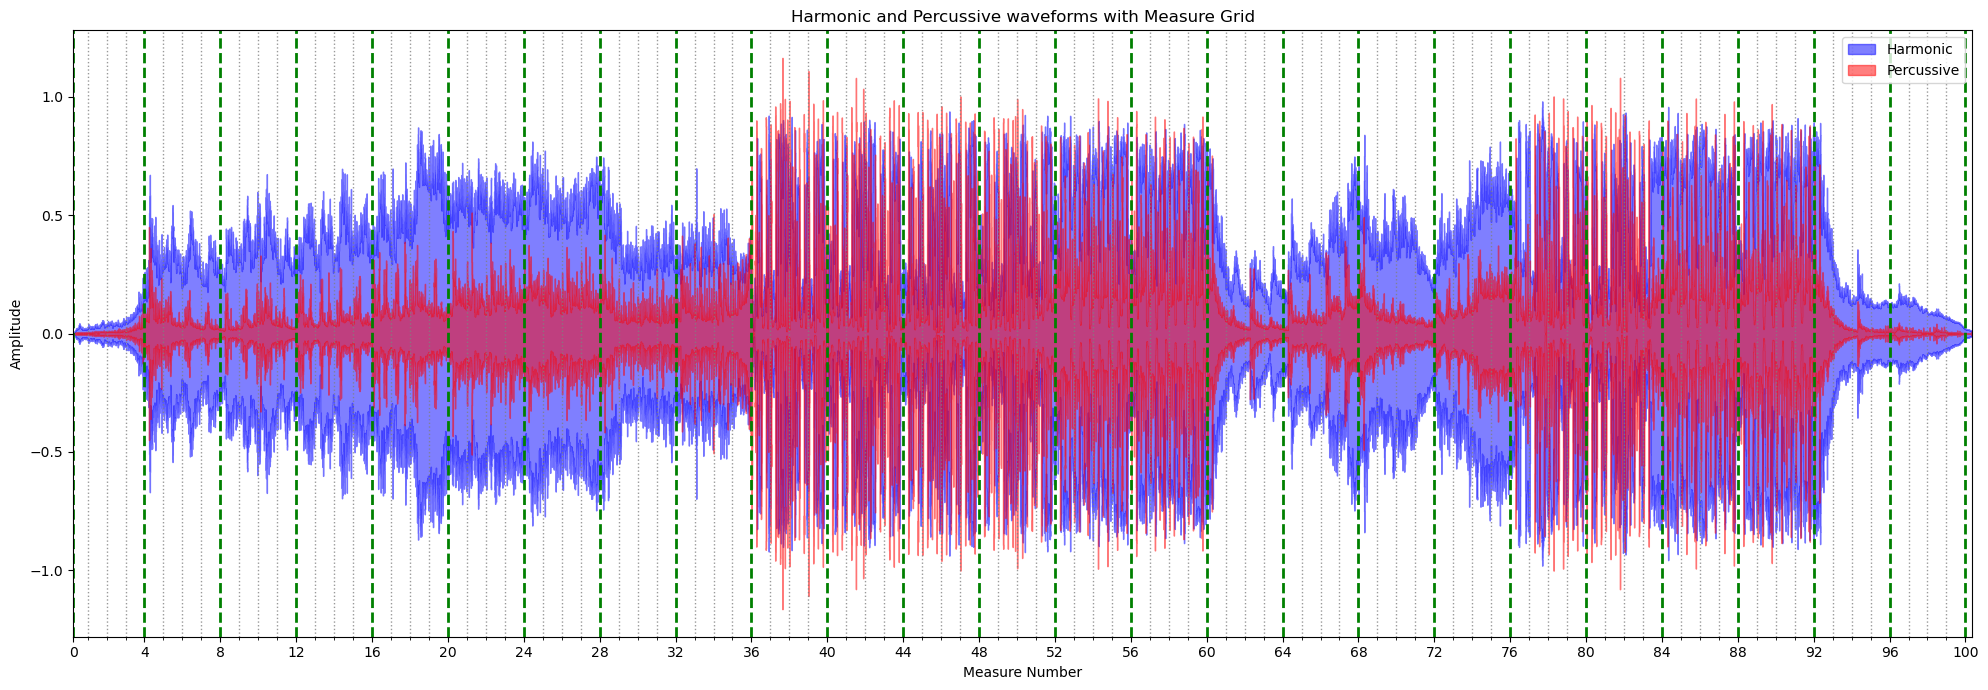

In [31]:
fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax, label='Harmonic', color='b')
librosa.display.waveshow(y_perc, sr=sr, alpha=0.5, ax=ax, label='Percussive', color='r')
ax.set_xlim([0, duration])
apply_measure_grid(ax, measure_grid)
ax.set_ylabel('Amplitude')
ax.set(title='Harmonic and Percussive waveforms with Measure Grid')
ax.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'MelSpectrogram')

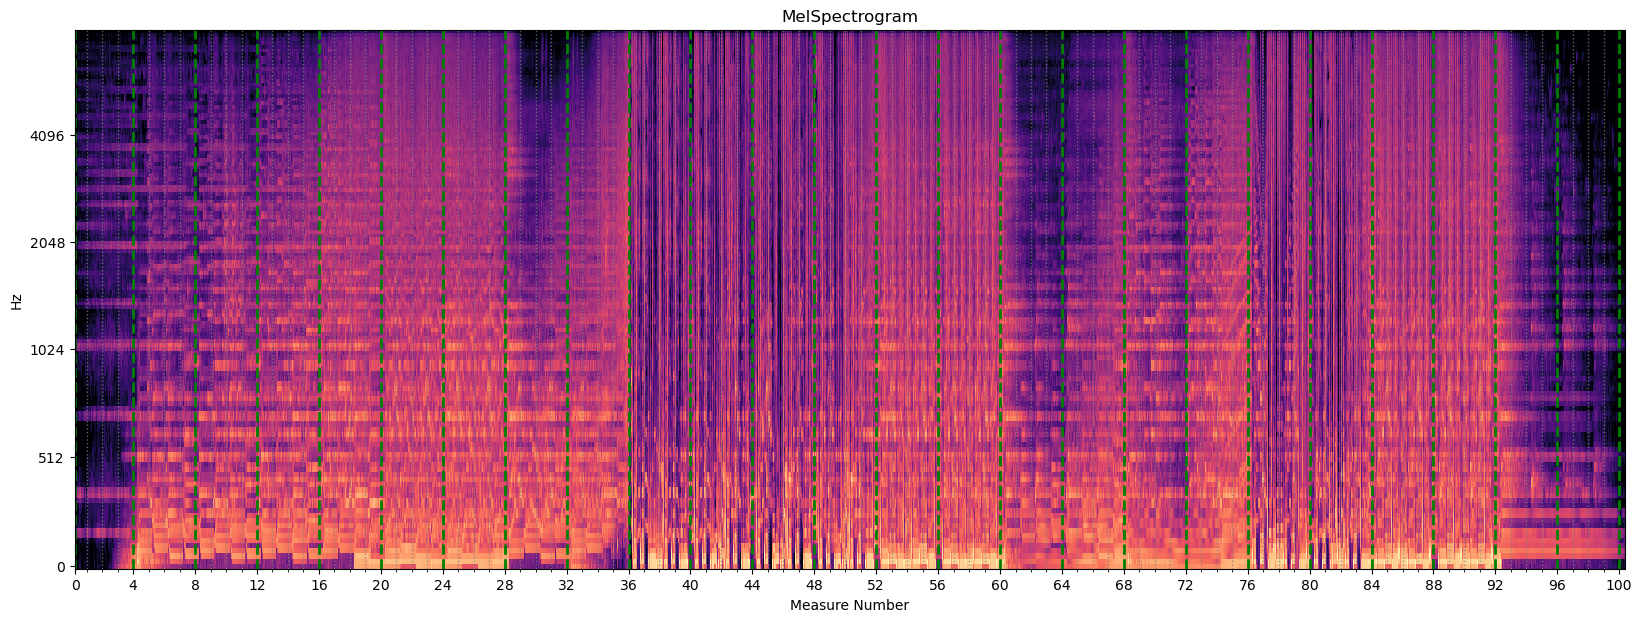

In [36]:
# Compute Melspectrogram
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

fig, ax = plt.subplots(figsize=(20, 7))
librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
apply_measure_grid(ax, measure_grid)
ax.set_title('MelSpectrogram')

In [42]:
import numpy as np
import pandas as pd
import librosa
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models

# Constants
audio_file = r"..\data\audio_files\processed\2.mp3"
hop_length = 512
sr = 22050
segment_length = measure_length
num_classes = 1

# Load the audio file and compute Mel spectrogram
y, sr = librosa.load(audio_file, sr=sr)
D = np.abs(librosa.stft(y))**2
S = librosa.feature.melspectrogram(S=D, sr=sr)
S_dB = librosa.power_to_db(S, ref=np.max)

# Preprocessing: Reshape and split data
# Reshape the spectrogram to match the input shape expected by the CNN
S_dB = S_dB.reshape((1, S_dB.shape[0], S_dB.shape[1], 1))

# Define CNN model architecture
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=S_dB.shape[1:]),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_classes, activation='softmax')  # Adjust activation based on the number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Adjust loss based on the task
              metrics=['accuracy'])

# Train the model
model.fit(S_dB, labels, epochs=num_epochs, batch_size=batch_size, validation_split=0.2)  # Adjust validation_split as needed

NameError: name 'labels' is not defined

In [44]:
tidy_df.loc[tidy_df["SongID"]== 2]

,SongID,start_time,end_time,label
2,2,92.2,138.3,chorus
3,2,184.3,230.4,chorus
